# Weekend Movie Trip

In [246]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [247]:
dfLinks=pd.read_csv("/Users/anissakhan/Dropbox/Nissa_stuff/KU_CS/EECS731/731-Project-3-Khan/Data/RawData/ml-latest-small/links.csv")
dfLinks.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [248]:
dfMovies=pd.read_csv("/Users/anissakhan/Dropbox/Nissa_stuff/KU_CS/EECS731/731-Project-3-Khan/Data/RawData/ml-latest-small/movies.csv")
dfMovies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [249]:
dfRatings=pd.read_csv("/Users/anissakhan/Dropbox/Nissa_stuff/KU_CS/EECS731/731-Project-3-Khan/Data/RawData/ml-latest-small/ratings.csv")
dfRatings["timestampRating"]=dfRatings["timestamp"]
dfRatings.drop(columns =["timestamp"], inplace = True) 
dfRatings.head()

,userId,movieId,rating,timestampRating
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [250]:
dfTags=pd.read_csv("/Users/anissakhan/Dropbox/Nissa_stuff/KU_CS/EECS731/731-Project-3-Khan/Data/RawData/ml-latest-small/tags.csv")
dfTags["timestampTag"]=dfTags["timestamp"]
dfTags.drop(columns =["timestamp"], inplace = True) 
dfTags.head()

,userId,movieId,tag,timestampTag
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [251]:
dfRatings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   userId           100836 non-null  int64  
 1   movieId          100836 non-null  int64  
 2   rating           100836 non-null  float64
 3   timestampRating  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [252]:
dfTags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   userId        3683 non-null   int64 
 1   movieId       3683 non-null   int64 
 2   tag           3683 non-null   object
 3   timestampTag  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [253]:
new = dfMovies["title"].str.split("(", n = 1, expand = True)
dfMovies["titleOnly"]=new[0]
dfMovies["year"]=new[1]
dfMovies.head()

,movieId,title,genres,titleOnly,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995)
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji,1995)
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men,1995)
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale,1995)
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II,1995)


In [254]:
dfMovies.dtypes

movieId       int64
title        object
genres       object
titleOnly    object
year         object
dtype: object

In [255]:
dfMovies['year'] = dfMovies['year'].astype("string")
dfMovies['titleOnly'] = dfMovies['titleOnly'].astype("string")
dfMovies['title'] = dfMovies['title'].astype("string")
dfMovies['genres'] = dfMovies['genres'].astype("string")
dfMovies.dtypes

movieId       int64
title        string
genres       string
titleOnly    string
year         string
dtype: object

In [256]:
new = dfMovies["year"].str.split(")", n = 1, expand = True)
dfMovies["year"]=new[0]
dfMovies.head()

,movieId,title,genres,titleOnly,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale,1995
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II,1995


In [257]:
dfAll=pd.merge(dfRatings, dfTags, left_on=['userId', 'movieId'], right_on=['userId', 'movieId'])
dfAll

,userId,movieId,rating,timestampRating,tag,timestampTag
0,2,60756,5.0,1445714980,funny,1445714994
1,2,60756,5.0,1445714980,Highly quotable,1445714996
2,2,60756,5.0,1445714980,will ferrell,1445714992
3,2,89774,5.0,1445715189,Boxing story,1445715207
4,2,89774,5.0,1445715189,MMA,1445715200
...,...,...,...,...,...,...
3471,606,6107,4.0,1171324428,World War II,1178473747
3472,606,7382,4.5,1171233924,for katie,1171234019
3473,610,3265,5.0,1479542010,gun fu,1493843984
3474,610,3265,5.0,1479542010,heroic bloodshed,1493843978


In [258]:
dfAll=pd.merge(dfAll, dfMovies, left_on=['movieId'], right_on=['movieId'])
dfAll

,userId,movieId,rating,timestampRating,tag,timestampTag,title,genres,titleOnly,year
0,2,60756,5.0,1445714980,funny,1445714994,Step Brothers (2008),Comedy,Step Brothers,2008
1,2,60756,5.0,1445714980,Highly quotable,1445714996,Step Brothers (2008),Comedy,Step Brothers,2008
2,2,60756,5.0,1445714980,will ferrell,1445714992,Step Brothers (2008),Comedy,Step Brothers,2008
3,62,60756,3.5,1528934376,comedy,1528934384,Step Brothers (2008),Comedy,Step Brothers,2008
4,62,60756,3.5,1528934376,funny,1528934381,Step Brothers (2008),Comedy,Step Brothers,2008
...,...,...,...,...,...,...,...,...,...,...
3471,606,1948,3.5,1177512639,British,1177512649,Tom Jones (1963),Adventure|Comedy|Romance,Tom Jones,1963
3472,606,5694,3.0,1172968972,70mm,1175638092,Staying Alive (1983),Comedy|Drama|Musical,Staying Alive,1983
3473,606,6107,4.0,1171324428,World War II,1178473747,Night of the Shooting Stars (Notte di San Lore...,Drama|War,Night of the Shooting Stars,"Notte di San Lorenzo, La"
3474,610,3265,5.0,1479542010,gun fu,1493843984,Hard-Boiled (Lat sau san taam) (1992),Action|Crime|Drama|Thriller,Hard-Boiled,Lat sau san taam


In [259]:
dfAll.dtypes

userId               int64
movieId              int64
rating             float64
timestampRating      int64
tag                 object
timestampTag         int64
title               string
genres              string
titleOnly           string
year                string
dtype: object

In [260]:
dfAll.titleOnly = dfAll.titleOnly.str.strip()
dfAll.year = dfAll.year.str.strip()

In [261]:
#print(dfAll['year'][0])

In [262]:
dfAll.dropna(subset = ["year"], inplace=True)

In [263]:
dfAll=dfAll.reset_index()

In [264]:
#print(len(dfAll['year']))

In [265]:
count=0
for i in range(0,len(dfAll['year'])):
    if(dfAll['year'][i].isnumeric()==False):
        #print(dfAll.iloc[i])
        dfAll.drop([i],inplace=True, axis=0)
        count=count+1
        
            
print('Times this error occurs =', count)

Times this error occurs = 318


In [266]:
dfAll=dfAll.reset_index()

In [267]:
dfAll.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3155 entries, 0 to 3154
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   level_0          3155 non-null   int64  
 1   index            3155 non-null   int64  
 2   userId           3155 non-null   int64  
 3   movieId          3155 non-null   int64  
 4   rating           3155 non-null   float64
 5   timestampRating  3155 non-null   int64  
 6   tag              3155 non-null   object 
 7   timestampTag     3155 non-null   int64  
 8   title            3155 non-null   string 
 9   genres           3155 non-null   string 
 10  titleOnly        3155 non-null   string 
 11  year             3155 non-null   string 
dtypes: float64(1), int64(6), object(1), string(4)
memory usage: 295.9+ KB


In [268]:
dfAll.head()

,level_0,index,userId,movieId,rating,timestampRating,tag,timestampTag,title,genres,titleOnly,year
0,0,0,2,60756,5.0,1445714980,funny,1445714994,Step Brothers (2008),Comedy,Step Brothers,2008
1,1,1,2,60756,5.0,1445714980,Highly quotable,1445714996,Step Brothers (2008),Comedy,Step Brothers,2008
2,2,2,2,60756,5.0,1445714980,will ferrell,1445714992,Step Brothers (2008),Comedy,Step Brothers,2008
3,3,3,62,60756,3.5,1528934376,comedy,1528934384,Step Brothers (2008),Comedy,Step Brothers,2008
4,4,4,62,60756,3.5,1528934376,funny,1528934381,Step Brothers (2008),Comedy,Step Brothers,2008


In [269]:
dfAll["genreCat"] = dfAll["genres"].astype('category')

In [270]:
dfAll.dtypes

level_0               int64
index                 int64
userId                int64
movieId               int64
rating              float64
timestampRating       int64
tag                  object
timestampTag          int64
title                string
genres               string
titleOnly            string
year                 string
genreCat           category
dtype: object

In [271]:
dfAll["genreCat"] = dfAll["genreCat"].cat.codes

In [272]:
dfAll

,level_0,index,userId,movieId,rating,timestampRating,tag,timestampTag,title,genres,titleOnly,year,genreCat
0,0,0,2,60756,5.0,1445714980,funny,1445714994,Step Brothers (2008),Comedy,Step Brothers,2008,189
1,1,1,2,60756,5.0,1445714980,Highly quotable,1445714996,Step Brothers (2008),Comedy,Step Brothers,2008,189
2,2,2,2,60756,5.0,1445714980,will ferrell,1445714992,Step Brothers (2008),Comedy,Step Brothers,2008,189
3,3,3,62,60756,3.5,1528934376,comedy,1528934384,Step Brothers (2008),Comedy,Step Brothers,2008,189
4,4,4,62,60756,3.5,1528934376,funny,1528934381,Step Brothers (2008),Comedy,Step Brothers,2008,189
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3150,3465,3468,573,52712,0.5,1248842748,HORRIBLE ACTING,1186722048,"Invisible, The (2007)",Crime|Drama|Fantasy|Mystery|Thriller,"Invisible, The",2007,236
3151,3466,3469,573,52712,0.5,1248842748,interesting,1186722060,"Invisible, The (2007)",Crime|Drama|Fantasy|Mystery|Thriller,"Invisible, The",2007,236
3152,3467,3470,606,1357,4.0,1173823837,music,1176765393,Shine (1996),Drama|Romance,Shine,1996,290
3153,3468,3471,606,1948,3.5,1177512639,British,1177512649,Tom Jones (1963),Adventure|Comedy|Romance,Tom Jones,1963,134


In [273]:
dfAll["genreCat"] = dfAll["genreCat"].astype('int')
dfAll["year"] = dfAll["year"].astype('int')

In [274]:
dfAll.dtypes

level_0              int64
index                int64
userId               int64
movieId              int64
rating             float64
timestampRating      int64
tag                 object
timestampTag         int64
title               string
genres              string
titleOnly           string
year                 int64
genreCat             int64
dtype: object

In [275]:
count=0
for i in range(0,len(dfAll['year'])):
    if(dfAll['year'][i] < 1900):
        #print(dfAll.iloc[i])
        dfAll.drop([i],inplace=True, axis=0)
        count=count+1
        
print('Times this error occurs =', count)

Times this error occurs = 8


In [278]:
#dfAll=dfAll.reset_index()

In [279]:
#dfAll.to_csv('test.csv')

In [280]:
dfTest=dfAll[['year','genreCat']].copy()
dfTest

,year,genreCat
0,2008,189
1,2008,189
2,2008,189
3,2008,189
4,2008,189
...,...,...
3150,2007,236
3151,2007,236
3152,1996,290
3153,1963,134


In [281]:
dbsc = DBSCAN(eps = 6, min_samples = 5).fit(dfTest)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

print(set(labels))

n_clusters_=len(set(labels))
n_noise_=list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, -1}
Estimated number of clusters: 30
Estimated number of noise points: 114


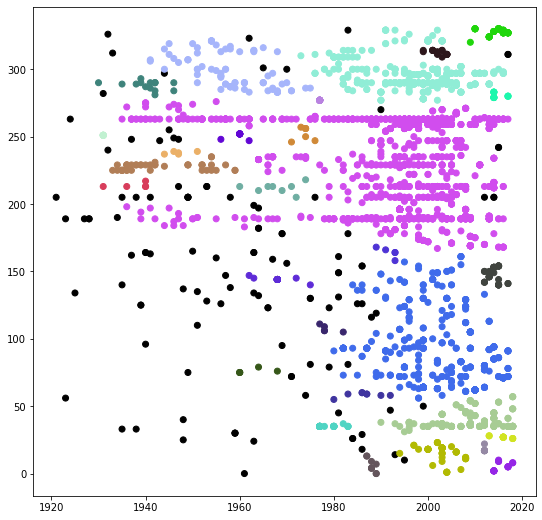

In [282]:
import random

colors={}
r = 0
b = 0
g = 0
color = (r, g, b)

colors[-1]=(0,0,0)
for i in range(0,n_clusters_):
    #while r==0 and b==0 and g==0:
    r = random.random()
    b = random.random()
    g = random.random()
    color = (r, g, b)
    colors[i]=color
    #print(colors[i])
    
cvec=[colors[label] for label in labels]

plt.figure(figsize=(9,9))
plt.scatter(dfTest['year'], dfTest['genreCat'], c=cvec)

plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = dfTest[class_member_mask & core_samples]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = dfTest[class_member_mask & ~core_samples]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()